In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score

from scipy.special import logsumexp

from mlgrad.funcs import Exp, Hinge, Hinge2
from sys import float_info

In [2]:
exp = np.exp
log = np.log
sqrt = np.sqrt

class MarginMaximizationExp:

    def __init__(self, alpha, tol=1.0e-9, n_iter=1000, n_iter_c=22, n_iter_w=22):
        self.tol = tol
        self.n_iter = n_iter
        self.n_iter_c = n_iter_c
        self.n_iter_w = n_iter_w
        self.c = None
        self.w = None
        self.alpha = alpha
    #
    def fit_w(self, X, Y):
        alpha = self.alpha
        tol = self.tol
        c = self.c
        w = w_min = self.w

        Xw = X @ w
        U = (Xw - c) * Y

        lval= lval_min = -logsumexp(-alpha * U) / alpha

        for K in range(self.n_iter_w):
            lval_prev = lval

            DU = exp(-alpha*U).sum()
            DUY = DU * Y

            w_1 = (X.T @ DUY) / (Xw @ DUY)
            wn = sqrt(w_1 @ w_1)
            w = w_1 / wn

            Xw = X @ w
            U = (Xw - c) * Y
            
            lval= logsumexp(-alpha * U) / alpha
            self.lvals.append(lval)

            if lval < lval_min:
                lval_min = lval
                w_min = w
            
            if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
                break

        self.w = w_min        
    #
    def fit_c(self, X, Y):
        alpha = self.alpha
        tol = self.tol
        c = c_min = self.c
        w = self.w

        I1 = (Y == -1)
        I2 = (Y == +1)
                
        Xw = X @ w
        U = (Xw - c) * Y

        lval= lval_min = -logsumexp(-alpha * U) / alpha

        for K in range(self.n_iter_c):
            lval_prev = lval

            c = (logsumexp(alpha*Xw[I1]) - logsumexp(-alpha*Xw[I2])) / (2*alpha)

            # Xw = X @ w
            U = (Xw - c) * Y
            
            lval= logsumexp(-alpha * U) / alpha
            self.lvals.append(lval)
            
            if lval > lval_min:
                lval_min = lval
                c_min = c
                
            if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
                break

        self.c = c_min        
    #
    def fit(self, X, Y):
        alpha = self.alpha
        tol = self.tol

        N, n = X.shape
        w = 2*np.random.random(n)-1
        w /= np.sqrt(w @ w)
        w_min = w
        self.w = w

        if self.c is None:
            c = c_min = 0
            self.c = c
        else:
            c = c_min = self.c

        Xw = X @ w
        U = (Xw - c) * Y
        
        lval= lval_min = logsumexp(-alpha * U) /alpha
        self.lvals = lvals = [lval]
        self.lvals2 = [lval]
        
        for K in range(self.n_iter):
            lval_prev = lval

            self.fit_w(X, Y)
            self.fit_c(X, Y)

            Xw = X @ w
            U = (Xw - c) * Y

            lval= logsumexp(-alpha * U) /alpha
            self.lvals2.append(lval)
            
            if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
                break
    
        self.K = K

    def evaluate(self, X):
        return X @ self.w - self.c

In [3]:
# class MarginMaximizationExp:

#     def __init__(self, alpha, tol=1.0e-9, n_iter=1000):
#         self.tol = tol
#         self.n_iter = n_iter
#         self.alpha = alpha
#         self.c = None
#         self.w = None
#     #
#     def fit(self, X, Y):
#         tol = self.tol
#         exp = np.exp
#         log = np.log
#         alpha = self.alpha

#         I1 = (Y == -1)
#         I2 = (Y == +1)

#         N, n = X.shape

#         if self.w is None:
#             w = 2*np.random.random(n)-1
#             w /= np.sqrt(w @ w)
#             w_max = w
#         else:
#             w_max = w = self.w
        
#         if self.c is None:
#             c = c_max = 0
#         else:
#             c = c_max = self.c

#         Xw = X @ w
#         U = (Xw - c) * Y

#         # U_min = U.min()
#         # U_max = U.max()

#         lval = lval_max = -logsumexp(-alpha * U) / alpha
#         lvals = [lval]

#         finish = False
#         for K in range(self.n_iter):

#             DU = exp(-alpha*U).sum()
#             DUY = DU * Y

#             w_1 = (X.T @ DUY) / (DUY @ Xw)
#             wn = np.sqrt(w_1 @ w_1)
#             w = w_1 / wn

#             # Xw1 = Xw[I1]
#             # Xw2 = Xw[I2]
#             # V1 = exp(alpha * Xw1).sum()
#             # V2 = exp(-alpha * Xw2).sum()
#             c =  (logsumexp(alpha*Xw[I1]) - logsumexp(-alpha*Xw[I2])) / (2*alpha)
            
#             Xw = X @ w
#             U = (Xw - c)*Y
    
#             # U_min = U.min()
#             # U_max = U.max()
            
#             lval = -logsumexp(-alpha * U) /alpha
#             lvals.append(lval)

#             if abs(lval - lval_max) < tol:
#                 finish = True
            
#             if lval > lval_max:
#                 lval_max = lval
#                 w_max = w
#                 c_max = c

#             if finish:
#                 break

#         self.K = K + 1
#         self.w = w_max
#         self.c = c_max
#         self.lvals = lvals

#     def evaluate(self, X):
#         return X @ self.w - self.c

In [4]:
X, Y = datasets.load_iris(return_X_y=True)
U = decomposition.PCA(n_components=2).fit_transform(X)

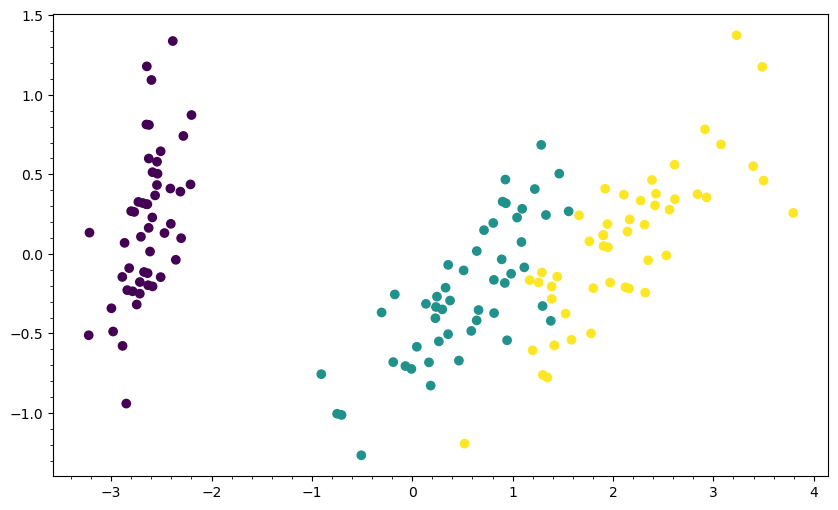

In [5]:
plt.figure(figsize=(10,6))
sc = plt.scatter(U[:,0], U[:,1], c=Y, s=36)
plt.minorticks_on()
plt.show()

In [6]:
U2 = U[Y != 0]
Y2 = Y[Y != 0]
np.putmask(Y2, Y2 == 1, -1)
np.putmask(Y2, Y2 == 2, +1)
Y2 = Y2.astype('d')
N = len(Y2)

In [7]:
def calc_zz(mod, xr, yr):
    xrange = np.linspace(xr[0], xr[1], 101)
    yrange = np.linspace(yr[0], yr[1], 101)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

In [8]:
mm = MarginMaximizationExp(7.)

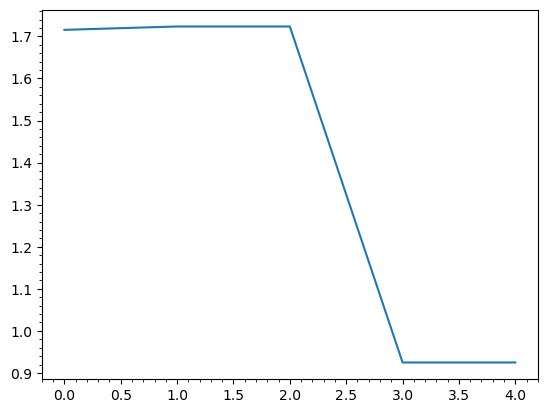

[0.935 0.354]
0


In [9]:
mm.fit(U2, Y2)
plt.plot(mm.lvals)
plt.minorticks_on()
plt.show()
print(mm.w)
print(mm.K)

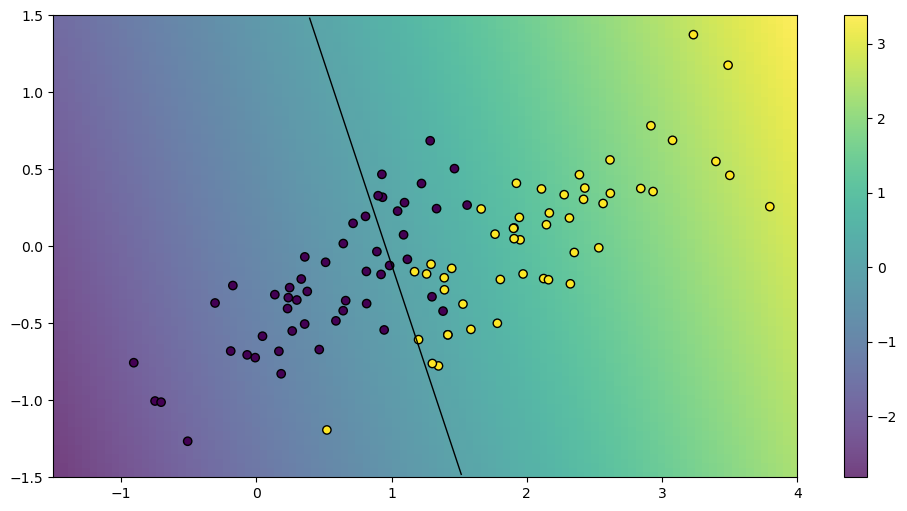

In [10]:
ZZ = calc_zz(mm, [-1.5, 4], [-1.5, 1.5])
extent = (-1.5, 4, -1.5, 1.5)
plt.figure(figsize=(12,6))
plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=36)
cb = plt.imshow(ZZ, origin='lower', extent=extent, alpha=0.75, aspect='auto')
plt.colorbar(cb)
plt.contour(ZZ, levels=[0], origin='lower', extent=extent, linewidths=1, colors='k')
plt.show()

In [11]:
accuracy_score(Y2, np.sign(mm.evaluate(U2)))

0.85